In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置英文字体
# plt.rcParams['font.sans-serif'] = ['Times New Roman']

# 检查GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 读取数据，指定编码为utf-8-sig
# 此处替换特征组合
X = pd.read_csv("E:/comorbidity/models/multi_features/语义+社交.csv", encoding='utf-8-sig')  
y = pd.read_excel("E:/comorbidity/models/multi_features/Y.xlsx")  


# 2. 查看y的数据，假设标签列名为 '标签'
y = y['标签']

# 3. 标签编码（Label Encoding）
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 将标签转换为整数
print(y_encoded)


# 4. 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# #考虑到之前的特征都是标准化后的，所以这里不需要再标准化
# X_scaled = X.values

# 5. 划分训练集、验证集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 6. 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# 7. 创建数据加载器
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 8. 定义DNN模型 - 防过拟合优化版
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        # 简化网络结构，减少参数
        self.layer1 = nn.Linear(input_size, hidden_size // 2)  # 减少隐藏层大小
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)  # 添加批归一化
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # 适中的dropout
        self.layer2 = nn.Linear(hidden_size // 2, hidden_size // 4)  # 进一步减少
        self.bn2 = nn.BatchNorm1d(hidden_size // 4)
        self.dropout2 = nn.Dropout(0.4)  # 递增dropout
        self.layer3 = nn.Linear(hidden_size // 4, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.layer2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.layer3(out)
        return out

# 设置随机种子函数
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 训练和评估函数
def train_and_evaluate(seed):
    set_random_seed(seed)
    
    # 重新初始化模型
    model = DNN(input_size, hidden_size, num_classes).to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # 训练历史记录
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    patience = 6
    counter = 0
    best_val_acc = 0.0
    num_epochs = 50
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 创建进度条
        progress_bar = tqdm(train_loader, desc=f'运行{seed} Epoch {epoch+1:2d}/{num_epochs}')
        
        for inputs, labels in progress_bar:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 更新进度条
            progress_bar.set_postfix({'Loss': f'{loss.item():.3f}', 'Acc': f'{100.*correct/total:.1f}%'})
        
        progress_bar.close()
        
        # 计算训练指标
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # 验证集评估
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_pred = torch.max(val_outputs, 1)
            val_correct = val_pred.eq(y_val_tensor).sum().item()
            val_acc = 100. * val_correct / y_val_tensor.size(0)
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 早停检查
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), f'best_dnn_model_{seed}.pth')
        else:
            counter += 1
            if counter >= patience:
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load(f'best_dnn_model_{seed}.pth'))
    
    # 测试集评估
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)
        y_pred_proba = torch.softmax(outputs, dim=1).cpu().numpy()
    
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    # 计算weighted指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.preprocessing import label_binarize
    
    accuracy = accuracy_score(y_test_np, y_pred_np)
    precision = precision_score(y_test_np, y_pred_np, average='weighted')
    recall = recall_score(y_test_np, y_pred_np, average='weighted')
    f1 = f1_score(y_test_np, y_pred_np, average='weighted')
    
    # 计算weighted AUC
    y_test_bin = label_binarize(y_test_np, classes=list(range(num_classes)))
    auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_weighted,
        'history': history,
        'y_pred': y_pred_np,
        'y_pred_proba': y_pred_proba,
        'seed': seed
    }

# 初始化模型参数
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(label_encoder.classes_)

# 运行10次实验
print("开始10次独立实验...")
results = []
for i in range(10):
    print(f"运行第{i+1}次实验 (seed={42+i})...")
    result = train_and_evaluate(42+i)
    results.append(result)
    print(f"第{i+1}次: 准确率={result['accuracy']:.4f}, F1={result['f1']:.4f}")

# 计算统计结果
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
stats = {}

for metric in metrics:
    values = [r[metric] for r in results]
    stats[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

# 输出最终结果
print("\n" + "="*50)
print("最终结果 (平均值±标准差)")
print("="*50)
print(f"准确率: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
print(f"精准率: {stats['precision']['mean']:.4f} ± {stats['precision']['std']:.4f}")
print(f"召回率: {stats['recall']['mean']:.4f} ± {stats['recall']['std']:.4f}")
print(f"F1值: {stats['f1']['mean']:.4f} ± {stats['f1']['std']:.4f}")
print(f"AUC值: {stats['auc']['mean']:.4f} ± {stats['auc']['std']:.4f}")

# 保存最后一次实验的预测结果用于后续可视化
final_result = results[-1]
y_pred = final_result['y_pred']
y_pred_proba = final_result['y_pred_proba']
y_test = y_test_tensor.cpu().numpy()
history = final_result['history']



使用设备: cuda:0
[2 1 1 ... 3 0 1]
开始10次独立实验...
运行第1次实验 (seed=42)...


运行42 Epoch 30/50: 100%|██████████| 447/447 [00:02<00:00, 169.83it/s, Loss=0.555, Acc=85.8%]


第1次: 准确率=0.8224, F1=0.8160
运行第2次实验 (seed=43)...


运行43 Epoch 35/50: 100%|██████████| 447/447 [00:02<00:00, 195.51it/s, Loss=0.853, Acc=86.5%]


第2次: 准确率=0.8262, F1=0.8213
运行第3次实验 (seed=44)...


运行44 Epoch 47/50: 100%|██████████| 447/447 [00:02<00:00, 175.61it/s, Loss=0.474, Acc=87.3%]


第3次: 准确率=0.8216, F1=0.8153
运行第4次实验 (seed=45)...


运行45 Epoch 33/50: 100%|██████████| 447/447 [00:02<00:00, 196.71it/s, Loss=0.733, Acc=86.4%]


第4次: 准确率=0.8225, F1=0.8175
运行第5次实验 (seed=46)...


运行46 Epoch 45/50: 100%|██████████| 447/447 [00:02<00:00, 182.38it/s, Loss=0.823, Acc=87.4%]


第5次: 准确率=0.8241, F1=0.8190
运行第6次实验 (seed=47)...


运行47 Epoch 38/50: 100%|██████████| 447/447 [00:02<00:00, 190.19it/s, Loss=0.609, Acc=87.0%]


第6次: 准确率=0.8246, F1=0.8185
运行第7次实验 (seed=48)...


运行48 Epoch 39/50: 100%|██████████| 447/447 [00:02<00:00, 183.21it/s, Loss=0.615, Acc=86.7%]


第7次: 准确率=0.8251, F1=0.8192
运行第8次实验 (seed=49)...


运行49 Epoch 42/50: 100%|██████████| 447/447 [00:02<00:00, 189.97it/s, Loss=0.420, Acc=87.1%]


第8次: 准确率=0.8237, F1=0.8181
运行第9次实验 (seed=50)...


运行50 Epoch 37/50: 100%|██████████| 447/447 [00:02<00:00, 194.00it/s, Loss=1.037, Acc=87.2%]


第9次: 准确率=0.8229, F1=0.8174
运行第10次实验 (seed=51)...


运行51 Epoch 23/50: 100%|██████████| 447/447 [00:02<00:00, 216.02it/s, Loss=0.607, Acc=84.2%]


第10次: 准确率=0.8199, F1=0.8139

最终结果 (平均值±标准差)
准确率: 0.8233 ± 0.0017
精准率: 0.8185 ± 0.0021
召回率: 0.8233 ± 0.0017
F1值: 0.8176 ± 0.0020
AUC值: 0.9262 ± 0.0009


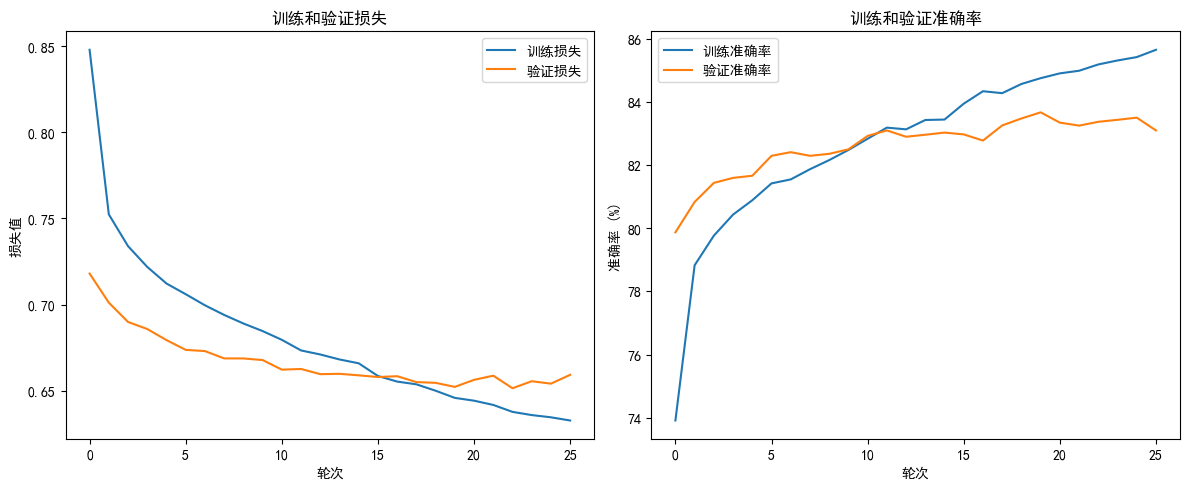

In [3]:
# 训练历史可视化
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='训练损失')
plt.plot(history['val_loss'], label='验证损失')
plt.title('训练和验证损失')
plt.xlabel('轮次')
plt.ylabel('损失值')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='训练准确率')
plt.plot(history['val_acc'], label='验证准确率')
plt.title('训练和验证准确率')
plt.xlabel('轮次')
plt.ylabel('准确率 (%)')
plt.legend()

plt.tight_layout()
plt.show()


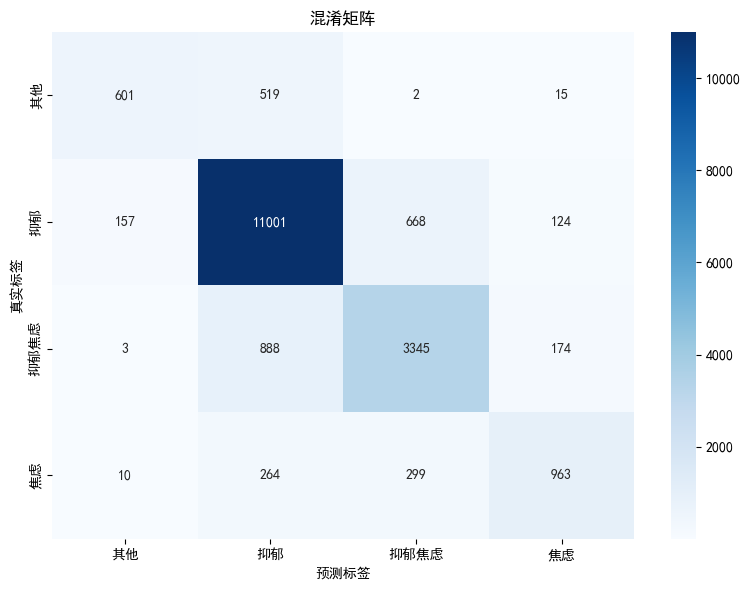

各类别准确率分析:
其他: 0.529 (52.9%)
抑郁: 0.921 (92.1%)
抑郁焦虑: 0.759 (75.9%)
焦虑: 0.627 (62.7%)


In [4]:

# 混淆矩阵可视化
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.tight_layout()
plt.show()

# 各类别准确率分析
print("各类别准确率分析:")
for i, class_name in enumerate(label_encoder.classes_):
    if cm[i, :].sum() > 0:
        class_acc = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: {class_acc:.3f} ({class_acc*100:.1f}%)")
    else:
        print(f"{class_name}: 无样本")


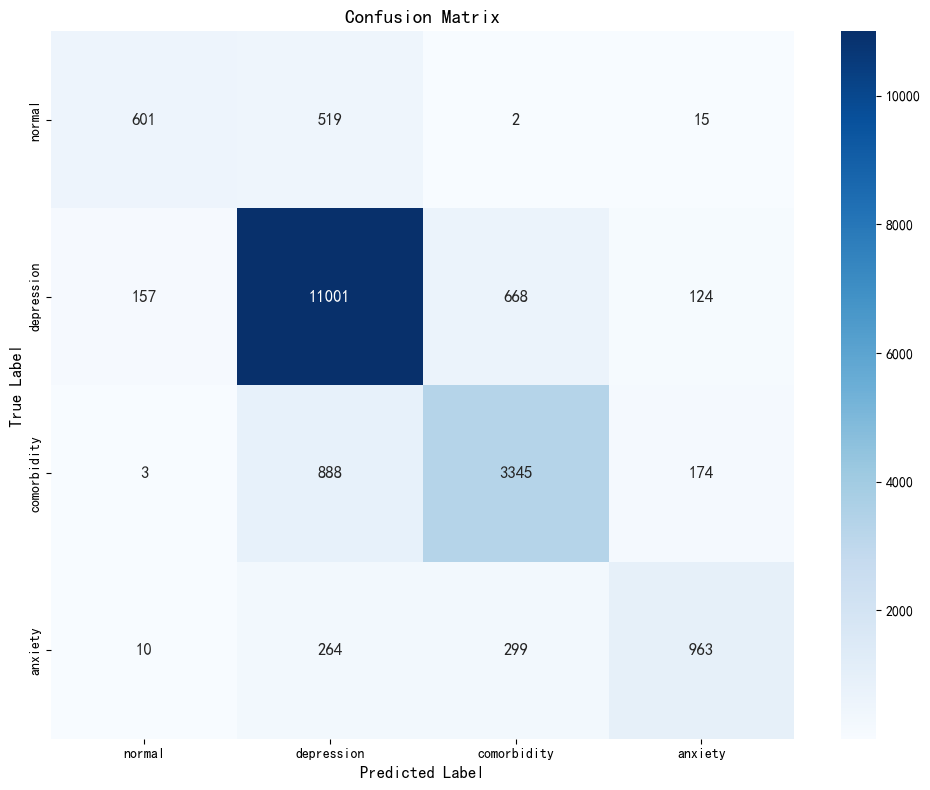

In [5]:
# 混淆矩阵可视化
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC', 'Times New Roman']
conf_matrix = confusion_matrix(y_test, y_pred)

# 定义中英文标签映射
chinese_to_english = {
    '其他': 'normal',
    '抑郁': 'depression',
    '焦虑': 'anxiety',
    '抑郁焦虑': 'comorbidity'
}

# 将label_encoder.classes_中的中文标签转换为英文
english_classes = [chinese_to_english.get(cls, cls) for cls in label_encoder.classes_]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=english_classes,  # 使用英文标签
            yticklabels=english_classes,  # 使用英文标签
            annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

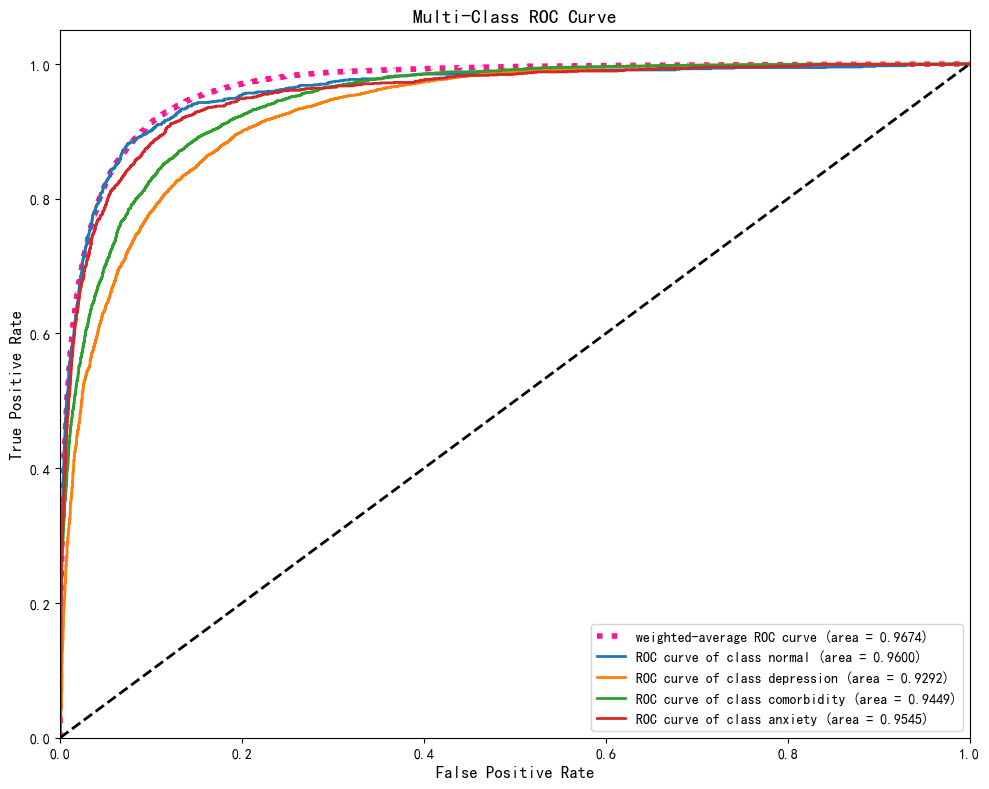

In [6]:
# 多分类ROC曲线可视化
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均ROC曲线和AUC
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# 定义中英文标签映射
chinese_to_english = {
    '其他': 'normal',
    '抑郁': 'depression',
    '焦虑': 'anxiety',
    '抑郁焦虑': 'comorbidity'
}

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr["weighted"], tpr["weighted"],
         label='weighted-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["weighted"]),
         color='deeppink', linestyle=':', linewidth=4)

# 使用英文标签替换中文标签
for i in range(n_classes):
    chinese_label = label_encoder.classes_[i]
    english_label = chinese_to_english.get(chinese_label, chinese_label)
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'
                   ''.format(english_label, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

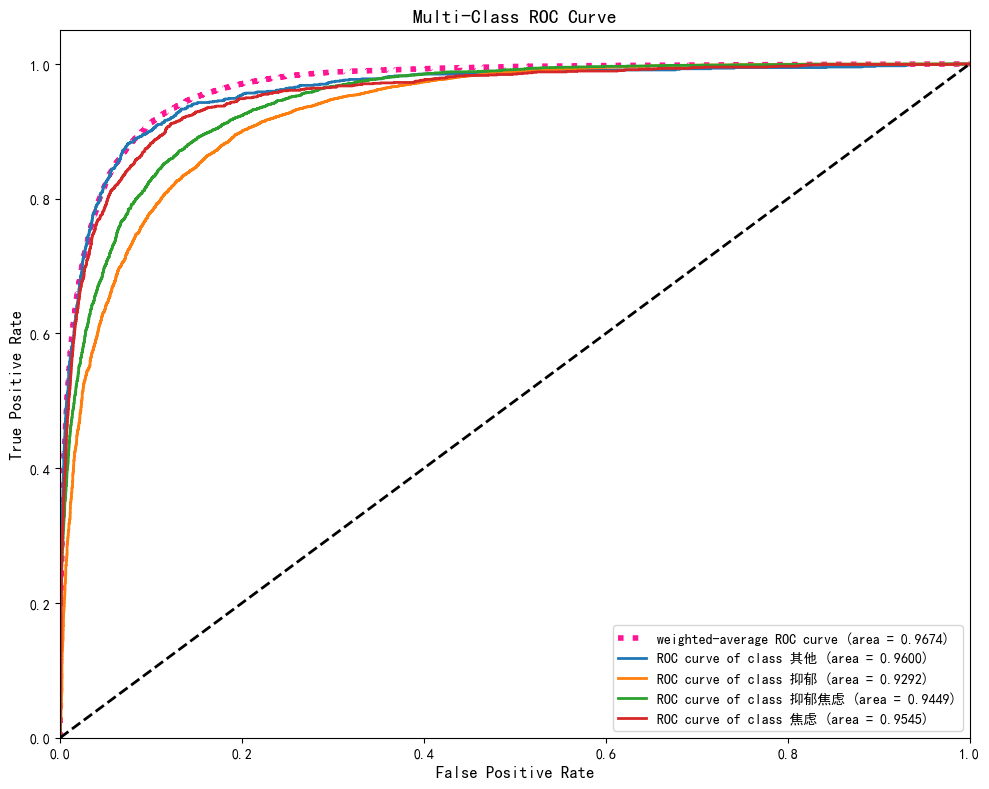

In [7]:
# 多分类ROC曲线可视化
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均ROC曲线和AUC
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr["weighted"], tpr["weighted"],
         label='weighted-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["weighted"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'
                   ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()